## Use scale to pre-processing

In [1]:
import os
import time
import torch
import argparse
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.multiprocessing as mp
import torch.utils.data
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import numpy

from sklearn import preprocessing

from models import VAE


device = torch.device('cuda:0')

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
# train_data = datasets.MNIST(root='data', train=True,
#                                    download=True, transform=transform)
# test_data = datasets.MNIST(root='data', train=False,
#                                   download=True, transform=transform)

# data_loader = DataLoader(
#     dataset=dataset, batch_size=args.batch_size, shuffle=True)
# print(len(train_data))

# dataset = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)


sides_3 = np.load('../data/force_torque_sensor/Dataset/3_sides/Data/data.npy')
sides_4 = np.load('../data/force_torque_sensor/Dataset/4_sides/Data/data.npy')
sides_5 = np.load('../data/force_torque_sensor/Dataset/5_sides/Data/data.npy')
sides_6 = np.load('../data/force_torque_sensor/Dataset/6_sides/Data/data.npy')
sides_200 = np.load('../data/force_torque_sensor/Dataset/200_sides/Data/data.npy')



In [2]:
def feature_normalize(data):
    mu = np.mean(data,axis=0)
    std = np.std(data,axis=0)
    return (data - mu)/std

def un_normalize(normalized_data, input_data):
    mu = np.mean(input_data,axis=0)
    std = np.std(input_data,axis=0)
    return normalized_data*std+mu

In [3]:
def extract_trials(x, n):
#     x = feature_normalize(x)
    x = preprocessing.minmax_scale(x, feature_range=(0,1))
    trials=[]
    trial=[]
    compare=0
    for sig in x:
        trial.append(sig[0:n])
        if sig[11] <= compare:
            d = 1002 - len(trial)
            if d >0:
                for i in range(d):
                    trial.append(np.zeros(len(sig[0:n])))
            trials.append(trial)
            trial=[]
        compare=sig[11]
    trials = np.array(trials)
    return trials       


In [4]:
num=10

sides_3_trials = extract_trials(sides_3, num)
# sides_4_trials = extract_trials(sides_4, num)
# sides_5_trials = extract_trials(sides_5, num)
# sides_6_trials = extract_trials(sides_6, num)
# sides_200_trials = extract_trials(sides_200, num)




print(sides_3[0])

print(np.shape(sides_3_trials))
print(len(sides_3_trials[1000]))
print(sides_3_trials[1000])

[-8.47151862e-03 -8.44647365e-03 -1.92757998e-05 -8.72229118e-02
 -8.22633362e-01  4.80666690e-02 -3.33000795e-02 -5.22700006e-02
 -7.75166669e-02  8.91666770e-03  1.00000000e+00  7.11917877e-04]
(1583, 1002, 10)
1002
[[0.99761829 0.35669136 0.6230216  ... 0.81527376 0.65169391 0.60907035]
 [0.99761829 0.35669136 0.6230216  ... 0.81747967 0.64997979 0.57950256]
 [0.99761829 0.35669136 0.6230216  ... 0.83126661 0.61341184 0.57412659]
 ...
 [0.99761829 0.35669136 0.6230216  ... 0.82244296 0.6076981  0.59563043]
 [0.99598465 0.44840978 0.51779794 ... 0.79430618 0.67270165 0.65831302]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [5]:
sides_3_trials = sides_3_trials[0:1530]
dataset = sides_3_trials

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 10

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
train_loader = data_loader
valid_loader = data_loader
test_loader = data_loader

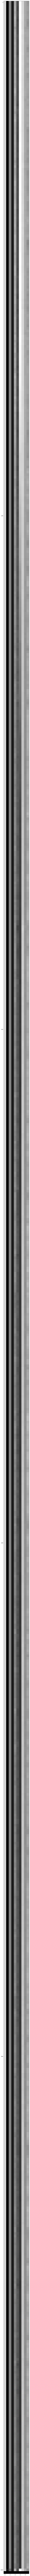

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loader)
images = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,500)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Loss function

In [7]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 1002*10), x.view(-1, 1002*10), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # elbo = recon_loss + self.beta * D_kl
    elbo = (BCE + KLD)/ x.size(0)
    return elbo

In [8]:
seed = 0
epochs = 50
latent_size = 2
num_processes = 2
learning_rate = 0.001
print_every = 100


vae = VAE(latent_size=latent_size).float().to(device)

# vae = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes).to(device)

use_cuda = torch.cuda.is_available
if use_cuda:
    vae.to(device)

logs = defaultdict(list)
    
epochs = epochs
for epoch in range(epochs):
    lr_havel = learning_rate
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr_havel)
    
    for iteration, data in enumerate(train_loader):
        signals = data
        signals = signals.view(signals.size(0), -1)
        if use_cuda:
            signals = signals.to(device).float()
        else:
            signals = signals.float()

        optimizer.zero_grad()
        recon_x, mean, log_var, z = vae(signals)
        elbo = loss_fn(recon_x, signals, mean, log_var)
        loss = elbo
        loss.backward()
        optimizer.step()

        logs['loss'].append(loss.item())

        if iteration % print_every == 0 or iteration == len(train_loader)-1:
            valid_correct = 0
            valid_total = 0
            test_correct = 0
            test_total = 0

            for valid_data in valid_loader:
                valid = valid_data
                valid = signals.view(valid.size(0), -1)
                if use_cuda:
                    input_valid = valid.to(device).float()
                else:
                    input_valid = valid.float()
                valid_recon_x, valid_mean, valid_log_var, valid_z = vae(input_valid)
                valid_elbo = loss_fn(valid_recon_x, input_valid, valid_mean, valid_log_var)
                criterion = nn.MSELoss()
                valid_loss = criterion(valid_recon_x, input_valid)
                logs['valid_elbo'].append(valid_elbo.item())
                logs['valid_loss'].append(valid_loss.item())
                valid_total +=1
                if valid_loss < 0.05:
                    valid_correct += 1
            valid_acc = valid_correct / valid_total  
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d} |Train_ELBO {:5f} |Valid_ELBO{:5f} |Valid_loss{:5f} |Valid_accuary{:5f} |Leaarning_rate{:5f}".format(
                epoch, epochs, iteration, len(train_loader)-1, loss.item(), valid_elbo.item(), valid_loss.item(), valid_acc, lr_havel))

    lr_havel = lr_havel*0.9
    torch.save(vae, 'vae_all_signals_1002_scale_0_1_unscale.pkl')  

Epoch 00/50 Batch 0000/152 |Train_ELBO 7208.761230 |Valid_ELBO7209.551758 |Valid_loss0.065587 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/50 Batch 0100/152 |Train_ELBO 6521.925781 |Valid_ELBO6444.089844 |Valid_loss0.039404 |Valid_accuary0.973856 |Leaarning_rate0.001000
Epoch 00/50 Batch 0152/152 |Train_ELBO 6272.028809 |Valid_ELBO6419.882812 |Valid_loss0.030092 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0000/152 |Train_ELBO 6347.458008 |Valid_ELBO6569.982910 |Valid_loss0.040532 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0100/152 |Train_ELBO 6281.300293 |Valid_ELBO6340.961426 |Valid_loss0.028011 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0152/152 |Train_ELBO 6346.653809 |Valid_ELBO6435.548340 |Valid_loss0.028815 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 02/50 Batch 0000/152 |Train_ELBO 6187.587891 |Valid_ELBO6495.452637 |Valid_loss0.030081 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 02/50 B

Epoch 19/50 Batch 0152/152 |Train_ELBO 6023.358887 |Valid_ELBO5956.398926 |Valid_loss0.011336 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 20/50 Batch 0000/152 |Train_ELBO 6147.387207 |Valid_ELBO6137.180664 |Valid_loss0.016426 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 20/50 Batch 0100/152 |Train_ELBO 5945.413086 |Valid_ELBO5981.767578 |Valid_loss0.013581 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 20/50 Batch 0152/152 |Train_ELBO 6133.787598 |Valid_ELBO6096.524414 |Valid_loss0.010959 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 21/50 Batch 0000/152 |Train_ELBO 6217.410156 |Valid_ELBO6196.923340 |Valid_loss0.016297 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 21/50 Batch 0100/152 |Train_ELBO 5984.189453 |Valid_ELBO5899.718262 |Valid_loss0.011678 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 21/50 Batch 0152/152 |Train_ELBO 6197.132324 |Valid_ELBO6193.780762 |Valid_loss0.021140 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 22/50 B

Epoch 39/50 Batch 0100/152 |Train_ELBO 5962.239746 |Valid_ELBO5968.561035 |Valid_loss0.006719 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 39/50 Batch 0152/152 |Train_ELBO 5994.234863 |Valid_ELBO5995.100586 |Valid_loss0.008759 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 40/50 Batch 0000/152 |Train_ELBO 5763.744629 |Valid_ELBO5741.656250 |Valid_loss0.007499 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 40/50 Batch 0100/152 |Train_ELBO 5949.080566 |Valid_ELBO5895.955078 |Valid_loss0.008886 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 40/50 Batch 0152/152 |Train_ELBO 5815.365723 |Valid_ELBO5786.917480 |Valid_loss0.012425 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 41/50 Batch 0000/152 |Train_ELBO 5813.361816 |Valid_ELBO5767.212891 |Valid_loss0.006628 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 41/50 Batch 0100/152 |Train_ELBO 6019.315430 |Valid_ELBO5981.634766 |Valid_loss0.011660 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 41/50 B

# 2. Use the oringinal signal to Generate>>>>>>

In [9]:
vae = torch.load('vae_all_signals_1002_scale_0_1_unscale.pkl').to(device)


In [10]:
import torch.utils.data

batch_size = 10
test_loader = data_loader

vae=vae.to(device)


recon_signals=[]
latent_space=[]

for iteration, test in enumerate(test_loader):
    test = test.view(test.size(0), -1)
    test = test.to(device).float()
    test_recon_x, test_mean, test_log_var, test_z = vae(test)
    test_recon_x = test_recon_x.view(batch_size, 1002, 10)
    test_recon_x=test_recon_x.cpu().detach().numpy()
    latent_space=test_z.cpu().detach().numpy()

    recon_signals.extend(test_recon_x)
#     latent_space.extend(latent_space)
    
    if iteration ==10:
        break
    
recon_signals = np.array(recon_signals)
latent_space = np.array(latent_space)

In [11]:
print(type(recon_signals[0]))
print(recon_signals[0])

print(len(recon_signals))
print(len(recon_signals[0]))
# print(recon_signals)

<class 'numpy.ndarray'>
[[0.5078503  0.6857545  0.49616787 ... 0.8317243  0.62283075 0.59991586]
 [0.505258   0.6854868  0.497572   ... 0.826713   0.6297612  0.6049696 ]
 [0.50561035 0.68453306 0.49381882 ... 0.83126396 0.64568126 0.5895931 ]
 ...
 [0.5096192  0.69571996 0.49794355 ... 0.828201   0.64046514 0.6384261 ]
 [0.45640352 0.52206963 0.3874171  ... 0.6733093  0.5089673  0.47040394]
 [0.0107734  0.0116676  0.00776429 ... 0.01389404 0.01115226 0.00999529]]
110
1002


In [12]:
# for i in range(len(recon_signals[0])):
#     recon_signals[:,i]=preprocessing.minmax_scale(
#         recon_signals[:,i], feature_range=(np.min(sides_3_trials[:,i]),np.max(sides_3_trials[:,i])))


# # recon_signals = un_normalize(recon_signals, sides_3_trials)
# generate_signals = recon_signals

# np.min(sides_3_trials[:,i])

## 2.1 Change shape

In [13]:
generate_signals=[]
for trial in recon_signals:
    generate_signals.extend(trial)
generate_signals = np.array(generate_signals)
print(np.shape(generate_signals))

(110220, 10)


## 2.1 Un pre-process(here we can select to train use normalize or scale and also generate)

In [14]:
for i in range(len(generate_signals[0])):
    generate_signals[:,i]=preprocessing.minmax_scale(
        generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
generated_signals=generate_signals

print(generated_signals[100])

[8.5579697e-04 4.2491425e-03 1.5096612e-04 7.9910435e-02 2.5229988e+00
 6.1574421e+00 1.1052055e+00 2.3284924e-01 3.9831042e-01 8.1001282e-02]


110220


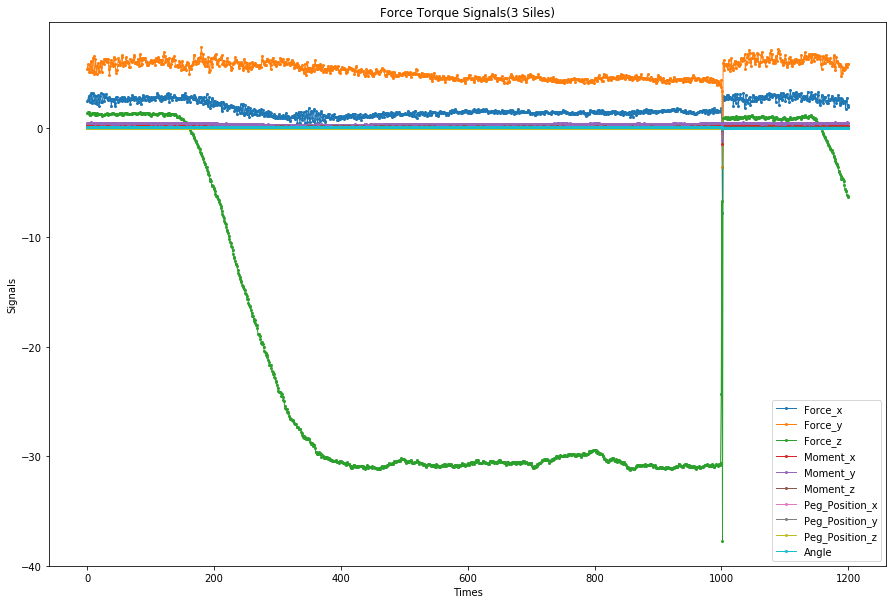

In [15]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = generated_signals
print(len(sides))

slip = 1200

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][:slip]
# Moment_z = sides[:,9][0:10:slip]

x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
plt.show()

# 3. Use the random latent space to Generate>>>>>>


In [16]:
print(latent_space)

[[-0.21548453  4.5791078 ]
 [-1.1720028   3.620516  ]
 [-0.03519656 -4.5704403 ]
 [-0.18837124  0.50341034]
 [ 1.3249025  -3.3224432 ]
 [ 0.651377   -0.4258017 ]
 [ 0.5474846   0.75405306]
 [-1.5499146   0.3711355 ]
 [-1.4741602  -0.85560143]
 [ 0.38231313  0.01183113]]


In [17]:
# batch_size = 10
z = torch.randn([batch_size, 2]).to(device)
print(z)

recon_x = vae.decoder(z)

print(recon_x)
print(np.shape(recon_x))

tensor([[-1.5520, -0.6660],
        [-1.3850, -1.0850],
        [ 1.1126, -0.9754],
        [-0.9697, -0.0580],
        [-0.7448,  0.0712],
        [-0.0158,  0.3938],
        [ 0.4615,  0.6816],
        [-1.2391, -0.5450],
        [ 0.3475,  0.9770],
        [ 0.5593, -0.4817]], device='cuda:0')
tensor([[0.4456, 0.3657, 0.4707,  ..., 0.0860, 0.0741, 0.0692],
        [0.5117, 0.5692, 0.4437,  ..., 0.0178, 0.0149, 0.0140],
        [0.2119, 0.9350, 0.5138,  ..., 0.0088, 0.0071, 0.0063],
        ...,
        [0.5345, 0.4157, 0.4378,  ..., 0.0274, 0.0226, 0.0211],
        [0.1302, 0.3904, 0.4888,  ..., 0.0077, 0.0052, 0.0052],
        [0.7990, 0.9205, 0.4823,  ..., 0.0041, 0.0034, 0.0033]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
torch.Size([10, 10020])


In [18]:
print(type(recon_x[0]))
print(recon_x[0])

print(len(recon_x))
print(len(recon_x[0]))

print(recon_x[0])

<class 'torch.Tensor'>
tensor([0.4456, 0.3657, 0.4707,  ..., 0.0860, 0.0741, 0.0692], device='cuda:0',
       grad_fn=<SelectBackward>)
10
10020
tensor([0.4456, 0.3657, 0.4707,  ..., 0.0860, 0.0741, 0.0692], device='cuda:0',
       grad_fn=<SelectBackward>)


In [19]:
recon_x = recon_x.view(batch_size,1002,10)
# generate_signals = recon_x.cpu().detach().numpy()

generate_signals=[]
for trial in recon_x:
    trial = trial.cpu().detach().numpy()
    generate_signals.append(trial)
generate_signals = np.array(generate_signals)


# print(np.shape(generate_signals))
print(len(generate_signals[0]))
# print(generate_signals[0])
# print(type(generate_signals))


1002


In [20]:
for i in range(len(generate_signals)):
    generate_signals[:,i]=preprocessing.minmax_scale(
        generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
generated_signals=generate_signals

print(len(generated_signals[0]))

1002


1002


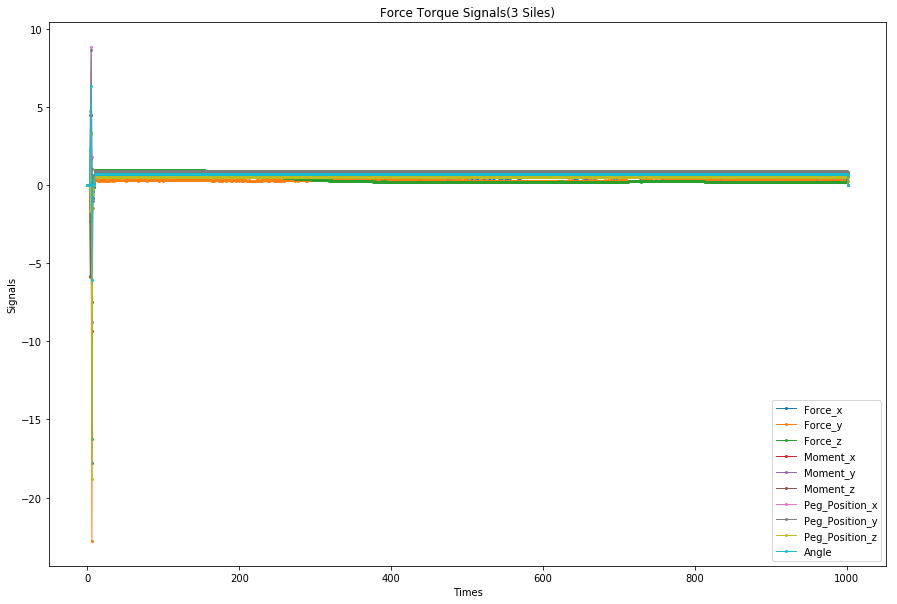

In [21]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = generated_signals[9]
print(len(sides))

slip = 1200

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][:slip]
# Moment_z = sides[:,9][0:10:slip]

x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
plt.show()